In [1]:
import pandas as pd
import datetime
import pyxirr
import yfinance as yf

In [2]:
class Account:

    def __init__(self, currency, timeline):
        self.currency = currency
        self.name = 'CASH.' + self.currency
        self.internal_transactions = pd.Series(0, index=timeline)
        self.external_transactions = pd.Series(0, index=timeline)
    
    def internal_flow(self, date, amount):
        self.internal_transactions.at[date] = self.internal_transactions.at[date] + amount

    def external_flow(self, date, amount):
        self.external_transactions.at[date] = self.external_transactions.at[date] + amount

    def process_data(self):
        self.holdings = self.internal_transactions.cumsum()
        self.invested_capital = self.external_transactions.cumsum()

In [3]:
class Fx:
    # home currency is account currency
    def __init__(self, home, foreign, timeline):
        day = datetime.timedelta(days=1)
        if foreign != home:
            if home == 'USD':
                self.name = foreign + '=X'
            else:
                self.name = home + foreign + '=X'
            self.fx_rates = yf.Ticker(self.name).history(start=timeline[0] + day, end=timeline[-1] + day)['Close'].reindex(index=timeline).fillna(method='ffill')
        else:
            self.fx_rates = 1

In [4]:
class Ticker:
    
    def __init__(self, name, timeline, fx_rates):
        self.name = name
        self.fx_rates = fx_rates
        self.transactions = pd.Series(0, index=timeline)
        day = datetime.timedelta(days=1)
        self.data = yf.Ticker(self.name).history(start=timeline[0] + day, end=timeline[-1] + day).reindex(index=timeline)
        self.local_prices = self.data['Close'].fillna(method='ffill')
        self.prices = self.local_prices.divide(self.fx_rates)
        self.dividends = self.data['Dividends'].fillna(0)
        self.splits = self.data['Stock Splits'].fillna(1).replace(0, 1).iloc[::-1].cumprod().iloc[::-1]

    def update(self, date, amount):
        self.transactions.at[date] = self.transactions.at[date] + amount

    def process_data(self):
        self.holdings = (self.transactions.multiply(self.splits)).cumsum()
        self.holdings_local_value = self.holdings.multiply(self.local_prices)
        self.holdings_value = self.holdings.multiply(self.prices).rename(self.name)

In [5]:
class Portfolio:

    def __init__(self, filename, currency):
        self.data = pd.read_csv(filename, sep=',', index_col='Date', parse_dates=True).sort_index()
        self.timeline = pd.date_range(start=self.data.index[0].date(), end=datetime.date.today())
        self.currency = currency
        self.account = Account(self.currency, self.timeline)
        self.tickers = dict() # dictionary with Ticker object at key='TICKER NAME'
        self.ccys = dict()

    def process_data(self):
        for date, transaction in self.data.iterrows():
            self.add_transaction(date, transaction)
        self.dividend()
        self.account.process_data()
        self.join_holdings()
        self.generate_stats()

    def add_transaction(self, date, transaction):
        getattr(self, transaction.Order)(date, transaction)
    
    def deposit(self, date, transaction):
        self.account.internal_flow(date, transaction.Quantity * transaction.Price - transaction.Fee)
        self.account.external_flow(date, transaction.Quantity * transaction.Price)

    def withdrawal(self, date, transaction):
        self.account.internal_flow(date, - transaction.Quantity * transaction.Price - transaction.Fee)
        self.account.external_flow(date, - transaction.Quantity * transaction.Price)
    
    def purchase(self, date, transaction):
        self.account.internal_flow(date,- transaction.Quantity * transaction.Price - transaction.Fee )
        ccy = self.ccys.setdefault(transaction.Currency, Fx(self.currency, transaction.Currency, self.timeline))
        tick = self.tickers.setdefault(transaction.Ticker, Ticker(transaction.Ticker, self.timeline, ccy.fx_rates))
        tick.update(date, transaction.Quantity)

    def sale(self, date, transaction):
        self.account.internal_flow(date, transaction.Quantity * transaction.Price - transaction.Fee)
        ccy = self.ccys.setdefault(transaction.Currency, Fx(self.currency, transaction.Currency, self.timeline))
        tick = self.tickers.setdefault(transaction.Ticker, Ticker(transaction.Ticker, self.timeline, ccy.fx_rates))
        tick.update(date, - transaction.Quantity)

    def dividend(self):
        for ticker in self.tickers.values():
            ticker.process_data()
            # self.account.internal_transactions = self.account.internal_transactions + ticker.dividends.multiply(ticker.holdings).divide(ticker.fx_rates)

    def join_holdings(self):
        self.holdings = pd.DataFrame(self.account.holdings, columns=[self.account.name])
        for ticker in self.tickers.values():
            self.holdings = self.holdings.join(ticker.holdings_value)

    def generate_stats(self):
        self.value = self.holdings.sum(axis=1)
        self.pl = self.value - self.account.invested_capital
        self.pctpl = self.pl / self.account.invested_capital
        self.cash_flows = - self.account.external_transactions
        self.cash_flows.iloc[-1] = self.cash_flows.iloc[-1] + self.value.iloc[-1]
        self.xirr = pyxirr.xirr(self.cash_flows.index, self.cash_flows.values)

    def run_benchmark(self, ticker):
        day = datetime.timedelta(days=1)
        benchmark = yf.download(tickers = ticker, start=self.timeline[0] + day, end=self.timeline[-1] + day)['Adj Close'].reindex(index=self.timeline, method='ffill').fillna(method='ffill')
        benchmark = benchmark/benchmark[0]-1
        self.benchmark = pd.concat({
            'Portfolio': self.pctpl,
            ticker: benchmark,
        }, axis=1)

In [6]:
portfolio = Portfolio('./samples/sample-currency.csv', 'EUR')

In [7]:
portfolio.process_data()

In [8]:
portfolio.run_benchmark('SPY')

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:>

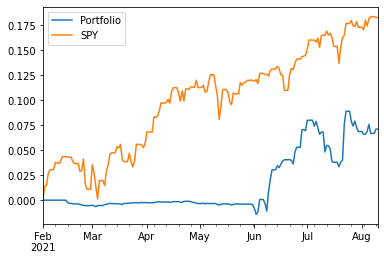

In [9]:
portfolio.benchmark.plot()

<AxesSubplot:ylabel='2021-08-10 00:00:00'>

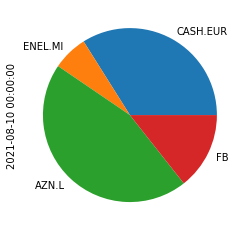

In [10]:
portfolio.holdings.iloc[-1].plot.pie()

In [11]:
portfolio.xirr

0.08319373031797173

<AxesSubplot:>

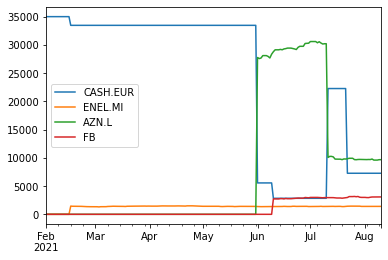

In [12]:
portfolio.holdings.plot()

In [13]:
portfolio.value.iloc[-1]

21424.143592995428